In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from sklearn.model_selection import StratifiedKFold

In [2]:
#Retrieve and load the Olivetti faces dataset
dataset = datasets.fetch_olivetti_faces()

# Intial data exploration

In [3]:
dataset.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

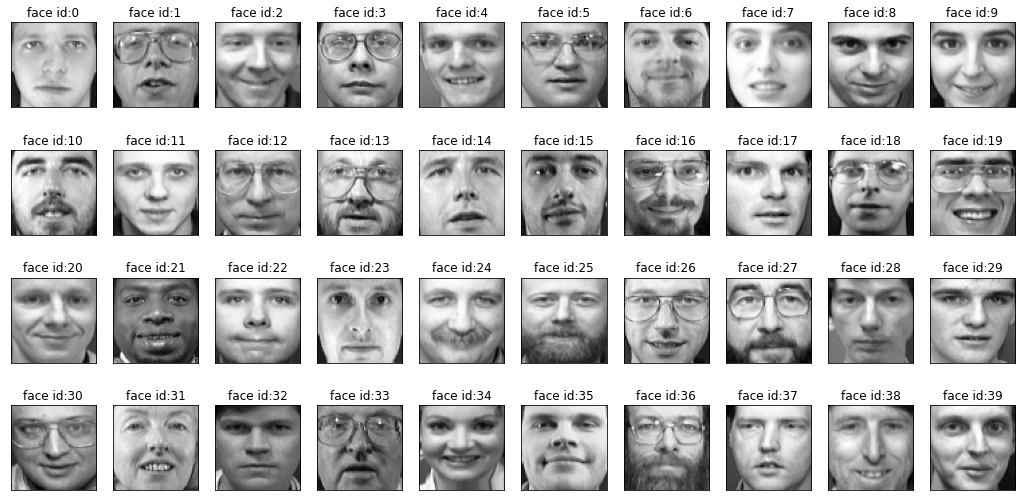

In [4]:
# Vizualizing the dataset
# plot a sample image for each of the 40 classes

images = dataset.images 

fig = plt.figure(figsize=(18,9)) 

for unique_id in range(40): 
    image_index = unique_id*10
    img_grid = fig.add_subplot(4, 10,  unique_id+1)
    img_grid.imshow(images[image_index], cmap='gray')
    img_grid.set_xticks([])
    img_grid.set_yticks([])
    img_grid.set_title("face id:{}".format(unique_id))

plt.show()

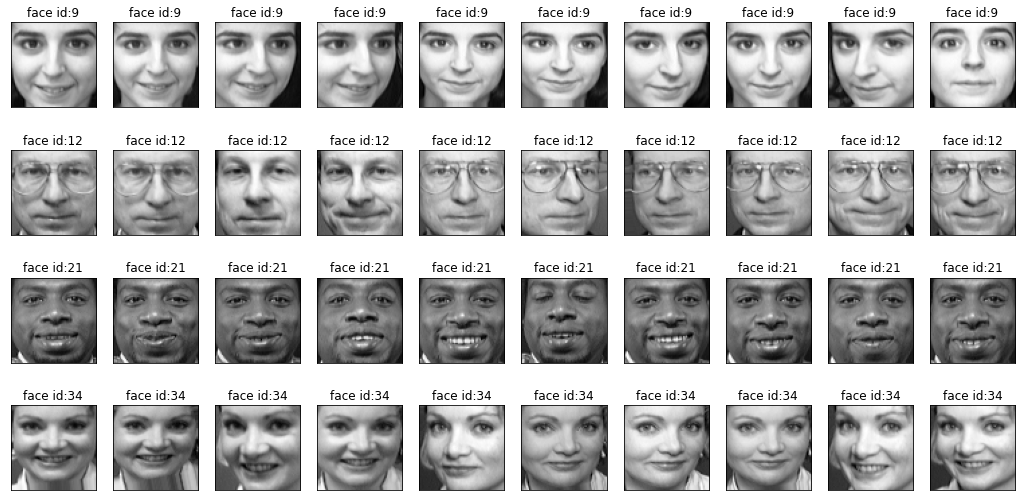

In [5]:
# plot all the 10 faces for 4 classes

fig = plt.figure(figsize=(18,9)) 
spec = fig.add_gridspec(ncols=10, nrows=4)

for i, class_id in enumerate([9, 12, 21, 34]): 
    for j in range(10):
        image_index = class_id*10 + j 
        img_grid = fig.add_subplot(spec[i, j])
        img_grid.imshow(images[image_index], cmap='gray')
        img_grid.set_xticks([])
        img_grid.set_yticks([])
        img_grid.set_title("face id:{}".format(class_id))

plt.show()

In [6]:
target = dataset.target
data = dataset.images.reshape(len(dataset.images),-1)

In [7]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(dataset.images.shape[1], dataset.images.shape[2]))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64


# Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.

In [8]:
#Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.
#train test split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=16)
train, test=next(strat_split.split(dataset.data, dataset.target))

In [9]:
X_train_valid=dataset.data[train]
y_train_valid=dataset.target[train]
X_test=dataset.data[test]
y_test=dataset.target[test]

In [10]:
#train validation split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=16)

train, validation=next(strat_split.split(X_train_valid, y_train_valid))

In [11]:
X_train=X_train_valid[train]
y_train=y_train_valid[train]
X_valid=X_train_valid[validation]
y_valid=y_train_valid[validation]

In [12]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(240, 4096) (240,)
(80, 4096) (80,)
(80, 4096) (80,)


# Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder

In [13]:
pca = PCA(0.99)
pca.fit(X_train)
X_train_99 = pca.transform(X_train)
pca.fit(X_test)
X_test_99 = pca.transform(X_test)
pca.fit(X_valid)
X_valid_99 = pca.transform(X_valid)
print(pca.explained_variance_ratio_.sum())

0.9908331


# Define an autoencoder with the following architecture:  

In [14]:
def build_autoencoder(latent_dim,hidden_layer,learning_rate):
    input_img = tf.keras.Input(shape=(4096,))
    encoded = layers.Dense(hidden_layer, activation='relu')(input_img)
    encoded = layers.Dense(latent_dim, activation='relu')(encoded)

    decoded = layers.Dense(hidden_layer, activation='relu')(encoded)
    decoded = layers.Dense(4096, activation='sigmoid')(decoded)

    autoencoder = tf.keras.Model(input_img, decoded)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
    return(autoencoder)

# Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer

In [15]:
latent_dim = [64, 100, 200]
learning_rate = [0.01,0.09,0.2]
hidden_layer = [200, 500, 1000]

In [16]:
for index in range(0,3):
    k_fold = 1
    model_accuracy = []

    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=88) 
    for train_index, test_index in skf.split(data, target):
        # split datasets
        x_train_split, x_test_split = data[train_index], data[test_index]
        y_train_split, y_test_split = target[train_index], target[test_index]
        
        # create and fit the model
        model= None
        model = build_autoencoder(latent_dim[index],hidden_layer[index],learning_rate[index])
        model.fit(x_train_split, x_train_split, epochs=10, batch_size=10, shuffle=True, validation_data=(x_test_split, x_test_split))
        model_accuracy.append(model.evaluate(x_test_split, x_test_split))

        print("----------------------------------")
        print("Model >>", index,"|| K FOLD >>", k_fold,"|| ACCURACY >>", model_accuracy[k_fold-1])
        print("----------------------------------")
        k_fold += 1


Epoch 1/10
32/32 [==============================] - 1s 9ms/step - loss: 0.0221 - val_loss: 0.0181
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0175
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0171 - val_loss: 0.0166
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 8/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0172
Epoch 10/10
3/3 [==============================] - 0s 3ms/step - loss: 0.0166
----------------------------------
Model

# Run the best model with the test set and display the original image and the reconstructed image.

In [17]:
model = build_autoencoder(64,200,0.01)  

model.fit(X_train, X_train,epochs=100,shuffle=True,validation_data=(X_valid, X_valid))

Epoch 1/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0312 - val_loss: 0.0197
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.0187
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.0183
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0180 - val_loss: 0.0183
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 11/100
8/8 [=

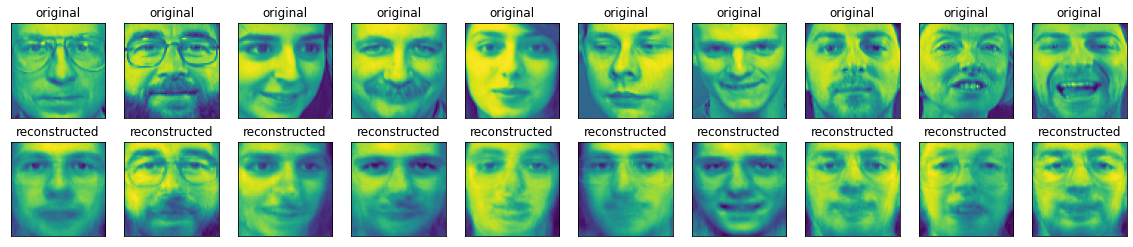

In [18]:
n = 10
pred = model.predict(X_test)
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(64, 64))
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(pred[i].reshape(64, 64))
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()